In [1]:
#To connect to my drive, in order to access datasets (.csv form)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cudf

from cuml.decomposition import IncrementalPCA as cuIncPCA
from sklearn.decomposition import SparsePCA, PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#Look up table to translate ensembl gene code into gene name
#Might need to install mygene, uncomment below
#!pip install mygene
import mygene

In [22]:
#This list holds the format for the hyperparameter tuning module in the hybrid_pipeline
CLASSIFIER_TUNING_COLUMNS = [
    "Combo Rank", "PCA_Type", "PC_Num", "Classifier",
    "n_estimators (rf)", "max_depth (rf)",
    "C (logreg)",
    "C (svm)", "gamma (svm)",
    "learning_rate (xgb)", "max_depth (xgb)",
    "F1_Score"
]

In [23]:
#This pipeline only processes one .csv file at a time
#It is designed to handle large datasets, but only one dataset at a time
#Change the csv_path below to the desired path

csv_path = "/content/drive/MyDrive/TCGA-BRCA_samples_labeled.csv"

In [24]:
import cudf
import cupy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import skew
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [33]:
class MasterPipeline:
    def __init__(self, csv_path, label_col='label'):
        """
        Orchestrates CorrelationPipeline, HybridPCAPipeline, and InterpretablePCAPipeline.
        """
        self.csv_path = csv_path
        self.label_col = label_col
        self.corr_pipeline = CorrelationPipeline(csv_path, label_col=label_col)
        self.hybrid_pipeline = HybridPCAPipeline(csv_path, label_col=label_col)
        self.interp_pipeline = None
        self.revolver_scores = None

    ### --- Stage 1: Run Correlation Pipeline ---
    def run_correlation_analysis(self, corr_threshold=0.5, log_transform=True):
        """
        Extracts highly correlated features with the target.
        """
        self.corr_pipeline.extract_high_corr_features(threshold=corr_threshold)
        return self.corr_pipeline.high_corr_features

    ### --- Stage 2: Run Hybrid PCA + LDA ---
    def run_hybrid_pipeline(self, pca_components=1000, final_components=100, model_num=3, lda_components=[2,5,10,20,50,100]):
        """
        Runs Hybrid PCA pipeline (Incremental + Revolver PCA + LDA tuning).
        """
        self.hybrid_pipeline.pca_components = pca_components
        self.hybrid_pipeline.final_components = final_components

        self.hybrid_pipeline.load_data()
        self.hybrid_pipeline.run_stage1_pca()
        self.hybrid_pipeline.run_stage2_pca_tuning(model_num=model_num)
        self.hybrid_pipeline.run_classifier_tuning()
        self.hybrid_pipeline.get_optimal_classifier_parameters()
        self.hybrid_pipeline.cross_validate_optimal_combos()
        self.hybrid_pipeline.run_lda_tuning(component_list=lda_components)

        # Build interpretable pipeline
        self.interp_pipeline = InterpretablePCAPipeline(self.hybrid_pipeline, top_n_genes=10000)
        self.interp_pipeline.extract_pca_loadings()
        self.interp_pipeline.extract_lda_loadings()
        return self.interp_pipeline

    ### --- Stage 3: Compare Correlation Genes with PCA/LDA ---
    def compare_correlation_with_pca_lda(self, top_n_corr_genes=1000):
        """
        Compares top correlated genes vs PC1 and LD1.
        Returns Jaccard, Spearman, Cosine.
        """
        corr_genes = set(self.corr_pipeline.high_corr_features[:top_n_corr_genes])

        # PCA mean vector (PC1)
        pca_vectors = []
        for k, series in self.interp_pipeline.full_component_loadings.items():
            pca_vectors.append(series)
        pca_mean = pd.concat(pca_vectors, axis=1).mean(axis=1)
        lda_vector = self.interp_pipeline.lda_full_vector

        from scipy.stats import spearmanr
        from sklearn.metrics.pairwise import cosine_similarity

        def compare_vectors(v1, v2, subset):
            shared = list(subset & set(v1.index) & set(v2.index))
            if not shared:
                return 0, None, None
            v1_shared, v2_shared = v1.loc[shared], v2.loc[shared]
            jaccard = len(shared) / len(set(v1.index) | set(v2.index))
            spearman_corr, _ = spearmanr(v1_shared, v2_shared)
            cos_sim = cosine_similarity(v1_shared.values.reshape(1,-1), v2_shared.values.reshape(1,-1))[0,0]
            return jaccard, spearman_corr, cos_sim

        jacc_pca, spear_pca, cos_pca = compare_vectors(pca_mean, pca_mean, corr_genes)
        jacc_lda, spear_lda, cos_lda = compare_vectors(pca_mean, lda_vector, corr_genes)

        return {
            "Correlation_vs_PCA": {"Jaccard": jacc_pca, "Spearman": spear_pca, "Cosine": cos_pca},
            "Correlation_vs_LDA": {"Jaccard": jacc_lda, "Spearman": spear_lda, "Cosine": cos_lda}
        }

    ### --- Stage 4: Visualizations ---
    def venn_correlation_pca_lda(self, top_n=1000):
        """
        Plots a Venn diagram for overlap between correlation genes, PCA, and LDA.
        """
        from matplotlib_venn import venn3
        import matplotlib.pyplot as plt

        corr_set = set(self.corr_pipeline.high_corr_features[:top_n])
        pca_set = set(self.interp_pipeline.full_component_loadings['PC1'].abs().nlargest(top_n).index)
        lda_set = set(self.interp_pipeline.lda_full_vector.abs().nlargest(top_n).index)

        venn3([corr_set, pca_set, lda_set], ('Correlation', 'PCA (PC1)', 'LDA (LD1)'))
        plt.title(f"Top {top_n} Gene Overlap: Correlation vs PCA vs LDA")
        plt.show()

    def plot_heatmaps(self):
        """
        Plots PCA-LDA and PCA-PCA heatmaps.
        """
        # PCA vs LDA
        pca_lda_df = self.interp_pipeline.compare_pca_lda_matrix(max_pcs=10, max_lds=1)
        self.interp_pipeline.plot_pca_lda_heatmap(pca_lda_df, metric="Jaccard_topN")
        self.interp_pipeline.plot_pca_lda_heatmap(pca_lda_df, metric="Spearman_all")
        self.interp_pipeline.plot_pca_lda_heatmap(pca_lda_df, metric="Cosine_all")

        # PCA vs PCA
        pca_pca_df = self.interp_pipeline.compare_pcs_matrix(max_pcs=25)
        self.interp_pipeline.plot_pcs_heatmap(pca_pca_df, metric="Jaccard_topN")
        self.interp_pipeline.plot_pcs_heatmap(pca_pca_df, metric="Spearman_all")
        self.interp_pipeline.plot_pcs_heatmap(pca_pca_df, metric="Cosine_all")

    # --- Existing methods (run_correlation_analysis, run_hybrid_pipeline, etc.) ---

    def save_revolver_scores(self, filepath="revolver_f1_scores.csv"):
        """
        Saves full revolver PCA+classifier F1 scores to a CSV.
        """
        if self.hybrid_pipeline.revolver_results is None:
            raise ValueError("Run run_hybrid_pipeline() first.")
        results_df = self.hybrid_pipeline.evaluate_classifiers(self.hybrid_pipeline.revolver_results)
        self.revolver_scores = results_df
        results_df.to_csv(filepath, index=False)
        print(f"Revolver scores saved to {filepath}")
        return results_df

    def plot_cumulative_variance(self):
        """
        Plots Stage 1 Incremental PCA cumulative explained variance.
        """
        return self.hybrid_pipeline.plot_stage1_cumulative_variance()

    def dashboard_visualization(self, top_n_venn=10000, top_n_bars=20, max_pcs=10):
        """
        Generates a single dashboard figure:
        - Venn diagram of correlation vs PCA vs LDA genes
        - PCA-LDA heatmap (Spearman)
        - PCA-PCA heatmap (Spearman)
        - Bar charts for top loadings (PC1 & LD1)
        """
        import matplotlib.pyplot as plt
        import seaborn as sns
        from matplotlib_venn import venn3

        # --- Data for plots ---
        corr_set = set(self.corr_pipeline.high_corr_features[:top_n_venn])
        pca_set = set(self.interp_pipeline.full_component_loadings['PC1'].abs().nlargest(top_n_venn).index)
        lda_set = set(self.interp_pipeline.lda_full_vector.abs().nlargest(top_n_venn).index)

        # PCA-LDA & PCA-PCA heatmaps
        pca_lda_df = self.interp_pipeline.compare_pca_lda_matrix(max_pcs=max_pcs, max_lds=1)
        pca_pca_df = self.interp_pipeline.compare_pcs_matrix(max_pcs=max_pcs)

        # Heatmap prep
        pca_lda_matrix = pca_lda_df.pivot(index="PC", columns="LD", values="Spearman_all")
        pcs = sorted(set(pca_pca_df['PC1']).union(set(pca_pca_df['PC2'])), key=lambda x: int(x.replace('PC','')))
        pca_pca_matrix = pd.DataFrame(index=pcs, columns=pcs, dtype=float)
        for _, row in pca_pca_df.iterrows():
            pca_pca_matrix.loc[row['PC1'], row['PC2']] = row['Spearman_all']
            pca_pca_matrix.loc[row['PC2'], row['PC1']] = row['Spearman_all']
        for pc in pcs: pca_pca_matrix.loc[pc, pc] = 1.0

        # Top-20 gene loadings for bar charts
        top_pca_genes = self.interp_pipeline.full_component_loadings['PC1'].abs().nlargest(top_n_bars)
        top_lda_genes = self.interp_pipeline.lda_full_vector.abs().nlargest(top_n_bars)

        # --- Build figure ---
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(3, 2)

        # 1. Venn diagram
        ax1 = fig.add_subplot(gs[0, 0])
        venn3([corr_set, pca_set, lda_set], ('Correlation', 'PCA (PC1)', 'LDA (LD1)'), ax=ax1)
        ax1.set_title(f"Top {top_n_venn} Gene Overlap")

        # 2. PCA-LDA heatmap
        ax2 = fig.add_subplot(gs[0, 1])
        sns.heatmap(pca_lda_matrix.astype(float), annot=False, cmap="coolwarm", cbar_kws={'label': 'Spearman'}, ax=ax2)
        ax2.set_title("PCA vs LDA Spearman Heatmap")

        # 3. PCA-PCA heatmap
        ax3 = fig.add_subplot(gs[1, :])
        sns.heatmap(pca_pca_matrix.astype(float), cmap="coolwarm", cbar_kws={'label': 'Spearman'}, ax=ax3)
        ax3.set_title("PCA vs PCA Spearman Heatmap")

        # 4. Bar charts (top loadings)
        ax4 = fig.add_subplot(gs[2, 0])
        top_pca_genes.plot(kind="bar", ax=ax4, color="purple")
        ax4.set_title("Top PCA (PC1) Loadings")
        ax4.set_ylabel("Loading")

        ax5 = fig.add_subplot(gs[2, 1])
        top_lda_genes.plot(kind="bar", ax=ax5, color="green")
        ax5.set_title("Top LDA (LD1) Loadings")
        ax5.set_ylabel("Loading")

        plt.tight_layout()
        plt.show()

    def get_top_hybrid_results(self, n=10, sort_by="F1-Score"):
        """
        Fetches the top PCA-classifier combinations from the Hybrid Pipeline.
        """
        return self.hybrid_pipeline.get_top_combinations(n=n, sort_by=sort_by)

    def map_ensembl_to_gene(ensembl_ids):
        """
        Maps a list of Ensembl IDs to gene symbols and biotypes using mygene.
        """
        mg = mygene.MyGeneInfo()
        results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol,type_of_gene', species='human')
        mapping = {}
        for r in results:
            mapping[r['query']] = {
                'symbol': r.get('symbol', 'N/A'),
                'biotype': r.get('type_of_gene', 'N/A')
            }
        return mapping

    def get_top_genes(self, n=10):
        """
        Returns a combined table of top N genes from PC1 and LD1.
        """
        pc1_df = self.hybrid_pipeline.get_top_genes_pc1(n)
        ld1_df = self.interpret_pipeline.get_top_genes_ld1(n)
        return pd.concat([pc1_df, ld1_df], ignore_index=True)

In [26]:
class CorrelationPipeline:
    def __init__(self, csv_path, label_col='label', normal_threshold=0.5, log_transform=True):
        self.csv_path = csv_path
        self.label_col = label_col
        self.normal_threshold = normal_threshold

        print("Loading dataset...")
        self.df = pd.read_csv(self.csv_path).drop(columns=['Unnamed: 0'], errors='ignore')
        self.labels = self.df[self.label_col]
        self.df = self.df.drop(columns=[self.label_col])

        if log_transform:
            print("Applying log2 transform to features...")
            self.df = np.log2(self.df + 1)

        self.high_corr_features = None
        self.df_corr = None

    #Skewness Distribution
    def feature_skewness_summary(self):
        skewness = self.df.apply(skew, nan_policy='omit')
        summary = pd.DataFrame({
            "Distribution Type": ["Normal", "Left-Skewed", "Right-Skewed"],
            "Count": [
                (skewness.abs() < self.normal_threshold).sum(),
                (skewness < -self.normal_threshold).sum(),
                (skewness > self.normal_threshold).sum()
            ]
        })
        return summary

    def sample_skewness_summary(self, log_transform=False):
        data = np.log2(self.df + 1) if log_transform else self.df.to_numpy()
        skewness = skew(data, axis=1, nan_policy='omit')
        summary = pd.DataFrame({
            "Distribution Type": ["Normal", "Left-Skewed", "Right-Skewed"],
            "Count": [
                (np.abs(skewness) < self.normal_threshold).sum(),
                (skewness < -self.normal_threshold).sum(),
                (skewness > self.normal_threshold).sum()
            ]
        })
        return summary

    def plot_sample_skewness(self, log_transform=False, bins=30, title="Sample Skewness Distribution"):

        data = np.log2(self.df + 1) if log_transform else self.df.to_numpy()
        skewness = skew(data, axis=1, nan_policy='omit')  # skewness per sample

        plt.figure(figsize=(8,5))
        plt.hist(skewness, bins=bins, color='purple', edgecolor='black', alpha=0.7)
        plt.axvline(0, color='red', linestyle='--', label='Symmetric')
        plt.title(title)
        plt.xlabel("Skewness")
        plt.ylabel("Number of Samples")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_pie(self, summary, title="Distribution Types"):
        plt.figure(figsize=(6,6))
        plt.pie(summary['Count'], labels=summary['Distribution Type'], autopct='%1.1f%%',
                startangle=140, wedgeprops={'edgecolor':'black'})
        plt.title(title)
        plt.tight_layout()
        plt.show()

    #Extract Feature Correlation
    def feature_label_correlation_summary(self, step=0.1):
        corr = self.df.corrwith(pd.Series(self.labels))
        bins = np.arange(-1, 1 + step, step)
        categories = pd.cut(corr, bins=bins, right=True, include_lowest=True)
        counts = categories.value_counts().sort_index()
        summary = pd.DataFrame({
            "Correlation Range": counts.index.astype(str),
            "Count": counts.values
        })
        return summary

    def plot_correlation_histogram(self, summary, title="Feature-Label Correlation Histogram"):
        plt.figure(figsize=(12,6))
        plt.bar(summary['Correlation Range'], summary['Count'], color='skyblue', edgecolor='black')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Correlation Range with Target Variable")
        plt.ylabel("Number of Features")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def extract_high_corr_features(self, threshold=0.5):
        corr = self.df.corrwith(pd.Series(self.labels))
        self.high_corr_features = corr[abs(corr) > threshold].index.tolist()
        self.df_corr = self.df[self.high_corr_features]
        print(f"Selected {len(self.high_corr_features)} features with |correlation| > {threshold}")
        return self.df_corr

    #Classifiers with correlation
    def corr_benchmark(self, use_pca=False, n_components=20):
        X = self.df_corr if self.df_corr is not None else self.df
        y = self.labels

        if use_pca:
            pca = PCA(n_components=n_components)
            X = pca.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'SVM': SVC(probability=True, random_state=42),
            'Voting': VotingClassifier(
                estimators=[
                    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
                    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
                    ('svm', SVC(probability=True, random_state=42))
                ],
                voting='soft'
            )
        }
        results = {}
        for name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            results[name] = f1_score(y_test, y_pred)
        return pd.DataFrame(list(results.items()), columns=['Classifier', 'F1-Score'])

    def plot_pca_separation(self, n_components=2, use_high_corr=True, cmap='coolwarm'):

        # Select data
        X = self.df_corr if (use_high_corr and self.df_corr is not None) else self.df
        y = self.labels

        # Run PCA
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)

        plt.figure(figsize=(8,6))

        if n_components == 2:
            plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap=cmap, alpha=0.7, edgecolor='k')
            plt.xlabel("PC1")
            plt.ylabel("PC2")
            plt.title("PCA (2D) of Features")
        elif n_components == 3:
            from mpl_toolkits.mplot3d import Axes3D
            ax = plt.figure(figsize=(8,6)).add_subplot(111, projection='3d')
            ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y, cmap=cmap, alpha=0.7)
            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_zlabel("PC3")
            ax.set_title("PCA (3D) of Features")

        plt.tight_layout()
        plt.show()

    #Cross validation
    def cross_val_classifiers(self, n_splits=5):
        X = self.df_corr if self.df_corr is not None else self.df
        y = self.labels
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'SVM': SVC(probability=True, random_state=42),
            'Voting': VotingClassifier(
                estimators=[
                    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
                    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
                    ('svm', SVC(probability=True, random_state=42))
                ],
                voting='soft'
            )
        }
        results = []
        for name, clf in classifiers.items():
            scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')
            results.append({'Classifier': name, 'Mean F1': round(scores.mean(), 4), 'Std F1': round(scores.std(), 4)})
        return pd.DataFrame(results)

In [27]:
class HybridPCAPipeline:
    def __init__(self, csv_path, label_col="label",
                 pca_components=1000, final_components=100,
                 batch_size=512, alpha=1.0, logreg_max_iter=5000):
        # Config
        self.csv_path = csv_path
        self.label_col = label_col
        self.pca_components = pca_components
        self.final_components = final_components
        self.batch_size = batch_size if pca_components <= batch_size else pca_components
        self.logreg_max_iter = logreg_max_iter  # NEW
        self.alpha = alpha

        # Data
        self.df = None
        self.X_gpu = None
        self.y_cpu = None
        self.gene_names = None

        # Stage 1
        self.intermediate_pca = None
        self.X_pca_cpu = None

        # Stage 2
        self.revolver_results = None
        self.top_combos = None
        self.pc_tuning_df = None
        self.optimal_pc_nums = None
        self.reduced_datasets = None

        # Stage 3
        self.classifier_tuning_df = None

    ### --- Data Loading ---
    def load_data(self, log_transform=True, scale=True):
        self.df = cudf.read_csv(self.csv_path)
        if 'Unnamed: 0' in self.df.columns:
            self.df = self.df.drop(columns=['Unnamed: 0'])
        X_cpu = self.df.drop(columns=[self.label_col]).to_pandas().astype('float32')

        if log_transform:
            X_cpu = np.log1p(X_cpu)
        if scale:
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_cpu = scaler.fit_transform(X_cpu)

        self.X_gpu = cudf.DataFrame.from_records(X_cpu)
        self.y_cpu = self.df[self.label_col].to_numpy()
        self.gene_names = list(self.df.drop(columns=[self.label_col]).columns)
        print(f"Data loaded: {self.X_gpu.shape[0]} samples, {self.X_gpu.shape[1]} features. Log={log_transform}, Scale={scale}")

    ### --- Stage 1: Incremental PCA ---
    def run_stage1_pca(self):
        print("Running GPU Incremental PCA...")
        start = time.time()
        self.intermediate_pca = cuIncPCA(n_components=self.pca_components,
                                         batch_size=self.batch_size)
        X_pca_gpu = self.intermediate_pca.fit_transform(self.X_gpu)
        self.X_pca_cpu = X_pca_gpu.to_cupy().get()
        print(f"Incremental PCA completed in {time.time() - start:.2f} sec.")
        return self.X_pca_cpu

    def plot_stage1_cumulative_variance(self):
        """
        Plots the cumulative explained variance of the Stage 1 Incremental PCA.
        """
        if self.intermediate_pca is None:
            raise ValueError("Run run_stage1_pca() first.")
        var_ratio = self.intermediate_pca.explained_variance_ratio_.to_numpy()
        cumulative_var = np.cumsum(var_ratio)

        plt.figure(figsize=(8,5))
        plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("Stage 1 Incremental PCA: Cumulative Explained Variance")
        plt.grid(True)
        plt.show()

        return cumulative_var

    ### --- Stage 2: Revolver PCA & Evaluation ---
    def revolver(self, X_pca_cpu, n_components=None, pca_subset=None):
        if n_components is None:
            n_components = self.final_components
        pca_methods = {
            "SparsePCA": SparsePCA(n_components=n_components, alpha=self.alpha, random_state=42, n_jobs=-1),
            "RotationPCA": PCA(n_components=n_components, svd_solver='full'),
            "KernelPCA_rbf": KernelPCA(n_components=n_components, kernel='rbf'),
            "KernelPCA_poly": KernelPCA(n_components=n_components, kernel='poly'),
            "KernelPCA_sigmoid": KernelPCA(n_components=n_components, kernel='sigmoid')
        }
        if pca_subset:
            if pca_subset not in pca_methods:
                raise ValueError(f"PCA subset {pca_subset} not recognized.")
            pca_methods = {pca_subset: pca_methods[pca_subset]}  # only one

        results = {}
        for name, model in pca_methods.items():
            start = time.time()
            X_reduced = model.fit_transform(X_pca_cpu)
            results[name] = np.asarray(X_reduced, dtype=np.float32)
            print(f"{name} completed in {time.time() - start:.2f} sec.")
        return results if not pca_subset else results[pca_subset]

    def evaluate_classifiers(self, revolver_results):
        classifiers = {
            "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
            "LogisticRegression": LogisticRegression(max_iter = self.logreg_max_iter),
            "SVM": make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True)),
            "XGBoost": XGBClassifier(
                n_estimators=300,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric='logloss',
                random_state=42
            )
        }
        results = []
        for pca_name, X_reduced in revolver_results.items():
            for clf_name, clf in classifiers.items():
                score = cross_val_score(clf, X_reduced, self.y_cpu, cv=5, scoring='f1').mean()
                results.append((pca_name, clf_name, score))
        results_df = pd.DataFrame(results, columns=["PCA_Type", "Classifier", "F1_Score"])
        results_df = results_df.sort_values(by="F1_Score", ascending=False).reset_index(drop=True)
        return results_df

    def top_combinations(self, results_df, top_n=3):
        return results_df.head(top_n)

    def stage2_pc_tuning(self, X_pca_cpu, top_combos, component_list=[2,10,50,100,200,500,800]):
        tuning_results = []
        for combo_rank, (_, row) in enumerate(top_combos.iterrows(), start=1):
            pca_type = row['PCA_Type']
            clf_name = row['Classifier']
            for n in component_list:
                X_reduced = self.revolver(X_pca_cpu, n_components=n, pca_subset=pca_type)
                clf = self._get_classifier(clf_name)
                score = cross_val_score(clf, X_reduced, self.y_cpu, cv=5, scoring='f1').mean()
                tuning_results.append((combo_rank, pca_type, clf_name, n, score))
        return pd.DataFrame(tuning_results, columns=["Combo Rank", "PCA_Type", "Classifier", "Num_Components", "F1_Score"])

    def get_optimal_pc_nums(self, pc_tuning_df):
        optimal_params = {}
        for (combo_rank, pca_type, clf_name), group in pc_tuning_df.groupby(['Combo Rank', 'PCA_Type', 'Classifier']):
            best_row = group.loc[group['F1_Score'].idxmax()]
            optimal_params[(combo_rank, pca_type, clf_name)] = int(best_row['Num_Components'])
        return optimal_params

    def get_stage2_reduced_datasets(self, X_pca_cpu, top_combos):
        reduced_data = {}
        for combo_rank, (_, row) in enumerate(top_combos.iterrows(), start=1):
            pca_type = row['PCA_Type']
            clf_name = row['Classifier']
            optimal_components = self.optimal_pc_nums[(combo_rank, pca_type, clf_name)]
            X_reduced = self.revolver(X_pca_cpu, n_components=optimal_components, pca_subset=pca_type)
            reduced_data[(combo_rank, pca_type, clf_name)] = X_reduced
        return reduced_data

    def _get_classifier(self, clf_name):
        if clf_name == "RandomForest":
            return RandomForestClassifier(n_estimators=200, random_state=42)
        elif clf_name == "LogisticRegression":
            return LogisticRegression(max_iter = self.logreg_max_iter)
        elif clf_name == "SVM":
            return make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True))
        elif clf_name == "XGBoost":
            return XGBClassifier(
                n_estimators=300,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric='logloss',
                random_state=42
            )
        else:
            raise ValueError(f"Unknown classifier: {clf_name}")

    ### --- Stage 2/3 Orchestration ---
    def run_stage2_pca_tuning(self, model_num=3, component_list=[2,10,50,100,200,500,800]):
        print("\nRunning Stage 2 PCA Tuning...")
        self.revolver_results = self.revolver(self.X_pca_cpu)
        results_df = self.evaluate_classifiers(self.revolver_results)
        self.top_combos = self.top_combinations(results_df, top_n=model_num)
        self.pc_tuning_df = self.stage2_pc_tuning(self.X_pca_cpu, self.top_combos, component_list)
        self.optimal_pc_nums = self.get_optimal_pc_nums(self.pc_tuning_df)
        print("Stage 2 PCA tuning complete.")
        return self.pc_tuning_df
    #--------------------------------------------------------------
    ### --- Stage 3: Classifier Tuning ---
    def rf_tuning(self, reduced_datasets, top_combos, n_estimators_list=[100,200,500], max_depth_list=[5,10,None]):
        tuning_results = []
        for combo_rank, (_, row) in enumerate(top_combos.iterrows(), start=1):
            pca_type = row['PCA_Type']; clf_name = row['Classifier']
            if clf_name != "RandomForest": continue
            pc_num = self.optimal_pc_nums[(combo_rank, pca_type, clf_name)]
            X_reduced = reduced_datasets[(combo_rank, pca_type, clf_name)]
            for n_est in n_estimators_list:
                for depth in max_depth_list:
                    clf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=42)
                    score = cross_val_score(clf, X_reduced, self.y_cpu, cv=5, scoring='f1').mean()
                    tuning_results.append([combo_rank,pca_type,pc_num,clf_name,n_est,depth, 0, 0, 0, 0, 0,score])
        return pd.DataFrame(tuning_results, columns=CLASSIFIER_TUNING_COLUMNS)

    def logreg_tuning(self, reduced_datasets, top_combos, C_list=[0.01,0.1,1,10,100]):
        tuning_results = []
        for combo_rank, (_, row) in enumerate(top_combos.iterrows(), start=1):
            pca_type = row['PCA_Type']; clf_name = row['Classifier']
            if clf_name != "LogisticRegression": continue
            pc_num = self.optimal_pc_nums[(combo_rank, pca_type, clf_name)]
            X_reduced = reduced_datasets[(combo_rank, pca_type, clf_name)]
            for C in C_list:
                clf = LogisticRegression(C=C, max_iter = self.logreg_max_iter)
                score = cross_val_score(clf, X_reduced, self.y_cpu, cv=5, scoring='f1').mean()
                tuning_results.append([combo_rank,pca_type,pc_num,clf_name, 0, 0,C, 0, 0, 0, 0,score])
        return pd.DataFrame(tuning_results, columns=CLASSIFIER_TUNING_COLUMNS)

    def svm_tuning(self, reduced_datasets, top_combos, C_list=[0.1,1,10], gamma_list=['scale','auto']):
        tuning_results = []
        for combo_rank, (_, row) in enumerate(top_combos.iterrows(), start=1):
            pca_type = row['PCA_Type']; clf_name = row['Classifier']
            if clf_name != "SVM": continue
            pc_num = self.optimal_pc_nums[(combo_rank, pca_type, clf_name)]
            X_reduced = reduced_datasets[(combo_rank, pca_type, clf_name)]
            for C in C_list:
                for gamma in gamma_list:
                    clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=C, gamma=gamma, probability=True))
                    score = cross_val_score(clf, X_reduced, self.y_cpu, cv=5, scoring='f1').mean()
                    tuning_results.append([combo_rank,pca_type,pc_num,clf_name, 0, 0, 0,C,gamma, 0, 0,score])
        return pd.DataFrame(tuning_results, columns=CLASSIFIER_TUNING_COLUMNS)

    def xgb_tuning(self, reduced_datasets, top_combos, learning_rates=[0.01,0.05,0.1], max_depths=[3,6,10]):
        tuning_results = []
        for combo_rank, (_, row) in enumerate(top_combos.iterrows(), start=1):
            pca_type = row['PCA_Type']; clf_name = row['Classifier']
            if clf_name != "XGBoost": continue
            pc_num = self.optimal_pc_nums[(combo_rank, pca_type, clf_name)]
            X_reduced = reduced_datasets[(combo_rank, pca_type, clf_name)]
            for lr in learning_rates:
                for depth in max_depths:
                    clf = XGBClassifier(n_estimators=300,learning_rate=lr,max_depth=depth,
                                        subsample=0.8,colsample_bytree=0.8,
                                        eval_metric='logloss',random_state=42)
                    score = cross_val_score(clf, X_reduced, self.y_cpu, cv=5, scoring='f1').mean()
                    tuning_results.append([combo_rank,pca_type,pc_num,clf_name, 0, 0, 0, 0, 0,lr,depth,score])
        return pd.DataFrame(tuning_results, columns=CLASSIFIER_TUNING_COLUMNS)

    def run_classifier_tuning(self):
        print("\nRunning Classifier Tuning...")
        self.reduced_datasets = self.get_stage2_reduced_datasets(self.X_pca_cpu, self.top_combos)
        all_results = []
        all_results.append(self.rf_tuning(self.reduced_datasets, self.top_combos))
        all_results.append(self.logreg_tuning(self.reduced_datasets, self.top_combos))
        all_results.append(self.svm_tuning(self.reduced_datasets, self.top_combos))
        all_results.append(self.xgb_tuning(self.reduced_datasets, self.top_combos))
        self.classifier_tuning_df = pd.concat(all_results, ignore_index=True)
        print("Classifier tuning complete.")
        return self.classifier_tuning_df


    def get_optimal_classifier_parameters(self):
        """
        Extracts the optimal hyperparameters for each PCA+Classifier combo based on max F1 score.
        Stores results in self.optimal_classifier_params.
        """
        if self.classifier_tuning_df is None:
            raise ValueError("Run run_classifier_tuning() first.")

        optimal_params = {}
        for (combo_rank, pca_type, clf_name), group in self.classifier_tuning_df.groupby(
            ["Combo Rank", "PCA_Type", "Classifier"]
        ):
            best_row = group.loc[group['F1_Score'].idxmax()]
            params = {
                "n_estimators": int(best_row["n_estimators (rf)"]),
                "max_depth_rf": int(best_row["max_depth (rf)"]),
                "C_logreg": float(best_row["C (logreg)"]),
                "C_svm": float(best_row["C (svm)"]),
                "gamma_svm": best_row["gamma (svm)"],
                "learning_rate_xgb": float(best_row["learning_rate (xgb)"]),
                "max_depth_xgb": int(best_row["max_depth (xgb)"])
            }
            optimal_params[(combo_rank, pca_type, clf_name)] = params

        self.optimal_classifier_params = optimal_params
        print("Optimal classifier parameters stored.")
        return optimal_params

    def cross_validate_optimal_combos(self, cv=5):
        """
        Runs cross-validation for each PCA+Classifier combo using optimal hyperparameters.
        Returns a DataFrame of mean F1 scores.
        """
        if not hasattr(self, 'optimal_classifier_params'):
            raise ValueError("Run get_optimal_classifier_parameters() first.")

        results = []
        for (combo_rank, pca_type, clf_name), params in self.optimal_classifier_params.items():
            X_reduced = self.reduced_datasets[(combo_rank, pca_type, clf_name)]

            # Build classifier with optimal params
            if clf_name == "RandomForest":
                clf = RandomForestClassifier(
                    n_estimators=params['n_estimators'] or 200,
                    max_depth=params['max_depth_rf'] if params['max_depth_rf'] > 0 else None,
                    random_state=42
                )
            elif clf_name == "LogisticRegression":
                clf = make_pipeline(
                    StandardScaler(),
                    LogisticRegression(C=params['C_logreg'] or 1.0, max_iter=self.logreg_max_iter)
                )
            elif clf_name == "SVM":
                clf = make_pipeline(
                    StandardScaler(),
                    SVC(C=params['C_svm'] or 1.0, gamma=params['gamma_svm'] or 'scale', kernel='rbf', probability=True)
                )
            elif clf_name == "XGBoost":
                clf = XGBClassifier(
                    n_estimators=300,
                    learning_rate=params['learning_rate_xgb'] or 0.05,
                    max_depth=params['max_depth_xgb'] or 6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    eval_metric='logloss',
                    random_state=42
                )
            else:
                raise ValueError(f"Unknown classifier: {clf_name}")

            score = cross_val_score(clf, X_reduced, self.y_cpu, cv=cv, scoring='f1').mean()
            results.append((combo_rank, pca_type, clf_name, score))

        final_results = pd.DataFrame(results, columns=["Combo Rank", "PCA_Type", "Classifier", "F1_Score"])
        print("Cross-validation with optimal parameters complete.")
        return final_results

    def lda_tuning(self, X_pca_cpu, component_list=[2,5,10,20,50,100]):
            """
            Tunes the number of PCA components fed into LDA for optimal F1 score.
            Works directly on Stage 1 Incremental PCA outputs.
            """
            tuning_results = []
            for n in component_list:
                if n >= X_pca_cpu.shape[1]:
                    continue  # skip if asking for more components than available
                X_reduced = X_pca_cpu[:, :n]  # take first n PCs
                lda = LinearDiscriminantAnalysis()
                score = cross_val_score(lda, X_reduced, self.y_cpu, cv=5, scoring='f1').mean()
                tuning_results.append((n, score))
            df = pd.DataFrame(tuning_results, columns=["Num_Components", "F1_Score"])
            best_row = df.loc[df['F1_Score'].idxmax()]
            self.best_lda = {
                "Num_Components": int(best_row["Num_Components"]),
                "F1_Score": float(best_row["F1_Score"])
            }
            print(f"Best LDA: {self.best_lda['Num_Components']} components (F1={self.best_lda['F1_Score']:.4f})")
            return df

    def run_lda_tuning(self, component_list=[2,5,10,20,50,100]):
        """
        Orchestrates LDA tuning after Stage 1 PCA.
        """
        print("\nRunning LDA tuning...")
        if self.X_pca_cpu is None:
            raise ValueError("Run run_stage1_pca() first.")
        self.lda_tuning_df = self.lda_tuning(self.X_pca_cpu, component_list)
        print("LDA tuning complete.")
        return self.lda_tuning_df

    def get_revolver_results(self):
            """
            Returns the full results DataFrame from the Revolver module.
            """
            if hasattr(self, 'revolver_results'):
                return self.revolver_results
            else:
                raise AttributeError("Revolver results are not available. Have you run the pipeline?")

    def get_top_combinations(self, n=10, sort_by="F1-Score"):
        """
        Returns the top-N PCA-classifier combinations based on a chosen metric.
        """
        df = self.get_revolver_results()
        return df.sort_values(by=sort_by, ascending=False).head(n)


    def get_top_genes_pc1(self, n=10):
        """
        Returns the top N genes by absolute loading in PC1.
        """
        if not hasattr(self, 'pca_model'):
            raise AttributeError("PCA model has not been fit. Run the pipeline first.")

        # Get PC1 loadings
        loadings = self.pca_model.components_[0]  # PC1
        gene_ids = self.gene_names  # Assuming you stored these when fitting
        abs_loadings = np.abs(loadings)

        # Sort and select top N
        top_idx = np.argsort(abs_loadings)[::-1][:n]
        top_genes = [(i+1, loadings[idx], 'PC1', gene_ids[idx]) for i, idx in enumerate(top_idx)]

        # Map Ensembl to gene names & biotypes
        mapping = map_ensembl_to_gene([g for _, _, _, g in top_genes])

        # Build final list
        results = []
        for rank, loading, axis, ensembl_id in top_genes:
            gene_symbol = mapping.get(ensembl_id, {}).get('symbol', 'N/A')
            biotype = mapping.get(ensembl_id, {}).get('biotype', 'N/A')
            results.append([rank, loading, axis, ensembl_id, gene_symbol, biotype])

        return pd.DataFrame(results, columns=['Rank', 'Loading', 'Axis Type', 'Ensembl Code', 'Gene Name', 'Biotype'])

In [28]:
class InterpretablePCAPipeline:
    def __init__(self, hybrid_pipeline, top_n_genes=10000):
        """
        hybrid_pipeline: Fitted HybridPCAPipeline instance (must include best_lda).
        top_n_genes: Number of top genes to extract for Jaccard & interpretability.
        """
        import cupy as cp
        import cudf

        self.hybrid = hybrid_pipeline
        self.top_n_genes = top_n_genes
        self.gene_names = self.hybrid.gene_names
        self.top_combos = self._filter_combos(self.hybrid.top_combos)
        self.optimal_pc_nums = self.hybrid.optimal_pc_nums
        self.optimal_clf_params = self.hybrid.optimal_classifier_params
        self.best_lda = getattr(self.hybrid, 'best_lda', None)

        # --- Convert Stage 1 loadings (Incremental PCA) to NumPy ---
        stage1_components = self.hybrid.intermediate_pca.components_
        if isinstance(stage1_components, cudf.DataFrame):
            self.stage1_loadings = stage1_components.to_pandas().to_numpy()
        elif hasattr(stage1_components, "__cuda_array_interface__"):  # cupy array
            self.stage1_loadings = cp.asnumpy(stage1_components)
        else:  # already numpy
            self.stage1_loadings = stage1_components

        # Storage
        self.loadings_dict = {}                # Melted DataFrames (top-N)
        self.full_component_loadings = {}      # Full PCA loadings per component
        self.full_lda_loadings = {}            # Full LDA loadings per discriminant
        self.lda_gene_loadings = None          # Melted top-N LDA
        self.lda_full_vector = None            # First LD vector
        self.comparison_metrics = None

    def _filter_combos(self, top_combos):
        """Ensure at least one interpretable PCA (Sparse/Rotation)."""
        interpretable = top_combos[~top_combos['PCA_Type'].str.startswith("KernelPCA")]
        if not interpretable.empty:
            return interpretable
        print("All top combos are KernelPCA. Substituting with next best interpretable combos...")
        all_results = self.hybrid.evaluate_classifiers(self.hybrid.revolver_results)
        interpretable_alts = all_results[~all_results['PCA_Type'].str.startswith("KernelPCA")]
        return interpretable_alts.head(len(top_combos))

    ### --- PCA Loadings ---
    def extract_pca_loadings(self):
        """
        Combine Stage1 (Incremental PCA) and Stage2 (Revolver PCA) loadings
        to map Stage2 components back to original genes.
        Stores full per-component vectors and melted top-N for interpretability.
        """
        for combo_rank, (_, row) in enumerate(self.top_combos.iterrows(), start=1):
            pca_type = row['PCA_Type']
            clf_name = row['Classifier']
            n_components = self.optimal_pc_nums.get((combo_rank, pca_type, clf_name), self.hybrid.final_components)

            if pca_type.startswith("KernelPCA"):
                print(f"Skipping {pca_type}: No interpretable loadings.")
                continue

            # Stage 2 PCA
            if pca_type == "SparsePCA":
                stage2_pca = SparsePCA(n_components=n_components, alpha=self.hybrid.alpha, random_state=42, n_jobs=-1)
            elif pca_type == "RotationPCA":
                stage2_pca = PCA(n_components=n_components, svd_solver='full')

            stage2_pca.fit(self.hybrid.X_pca_cpu)
            stage2_loadings = stage2_pca.components_
            combined_loadings = np.dot(stage2_loadings, self.stage1_loadings)  # [n_stage2 × n_genes]

            # --- Store full component loadings ---
            for i in range(n_components):
                comp_name = f"PC{i+1}"
                self.full_component_loadings[comp_name] = pd.Series(
                    combined_loadings[i, :], index=self.gene_names
                )

            # --- Melted DataFrame for interpretability ---
            loading_df = pd.DataFrame(combined_loadings, columns=self.gene_names)
            loading_df['Component'] = [f"PC{i+1}" for i in range(n_components)]
            loading_df = loading_df.melt(id_vars='Component', var_name='Gene', value_name='Loading')
            loading_df['Abs_Loading'] = loading_df['Loading'].abs()
            loading_df = loading_df.sort_values(['Component', 'Abs_Loading'], ascending=[True, False])
            top_genes = loading_df.groupby('Component').head(self.top_n_genes)
            self.loadings_dict[(combo_rank, pca_type, clf_name)] = top_genes

    def get_pca_loadings(self):
        """Return melted DataFrame of top-N PCA loadings."""
        combined = []
        for (combo_rank, pca_type, clf_name), df in self.loadings_dict.items():
            df['Combo Rank'] = combo_rank
            df['PCA_Type'] = pca_type
            df['Classifier'] = clf_name
            combined.append(df)
        return pd.concat(combined, ignore_index=True)

    ### --- LDA Loadings ---
    def extract_lda_loadings(self):
        """
        Fit LDA on tuned Stage1 PCA components and chain back to gene space.
        Stores full discriminant loadings and melted top-N for interpretability.
        """
        if not self.best_lda:
            raise ValueError("Run pipeline.run_lda_tuning() first.")
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

        n_components = self.best_lda['Num_Components']
        X_reduced = self.hybrid.X_pca_cpu[:, :n_components]

        lda = LinearDiscriminantAnalysis(solver='svd')
        lda.fit(X_reduced, self.hybrid.y_cpu)
        lda_loadings = lda.scalings_  # [n_components × n_discriminants]

        # Chain back to gene space
        combined_lda_loadings = np.dot(self.stage1_loadings[:n_components, :].T, lda_loadings)

        # --- Store full LDA discriminants ---
        for j in range(combined_lda_loadings.shape[1]):
            disc_name = f"LD{j+1}"
            self.full_lda_loadings[disc_name] = pd.Series(
                combined_lda_loadings[:, j], index=self.gene_names
            )

        # --- Store full first discriminant vector ---
        self.lda_full_vector = self.full_lda_loadings["LD1"]

        # --- Melted for interpretability ---
        lda_df = pd.DataFrame(combined_lda_loadings, index=self.gene_names,
                              columns=[f"LD{i+1}" for i in range(combined_lda_loadings.shape[1])])
        lda_long = lda_df.reset_index().melt(id_vars='index', var_name='Discriminant', value_name='Loading')
        lda_long.rename(columns={'index': 'Gene'}, inplace=True)
        lda_long['Abs_Loading'] = lda_long['Loading'].abs()
        lda_long = lda_long.sort_values(['Discriminant', 'Abs_Loading'], ascending=[True, False])
        self.lda_gene_loadings = lda_long.groupby('Discriminant').head(self.top_n_genes)
        return self.lda_gene_loadings

    ### --- PCA vs LDA Matrix ---
    def compare_pca_lda_matrix(self, max_pcs=10, max_lds=10):
        """
        Compare multiple PCA components vs multiple LDA discriminants.
        Returns a DataFrame with (PC, LD, Jaccard, Spearman, Cosine).
        """
        from scipy.stats import spearmanr
        from sklearn.metrics.pairwise import cosine_similarity

        results = []
        pcs = list(self.full_component_loadings.keys())[:max_pcs]
        lds = list(self.full_lda_loadings.keys())[:max_lds]

        for pc_name in pcs:
            for ld_name in lds:
                pc_vec = self.full_component_loadings[pc_name]
                ld_vec = self.full_lda_loadings[ld_name]

                # Align vectors
                common = pc_vec.index.intersection(ld_vec.index)
                pc_aligned, ld_aligned = pc_vec.loc[common], ld_vec.loc[common]

                # Spearman & Cosine
                spearman_corr, _ = spearmanr(pc_aligned, ld_aligned)
                cos_sim = cosine_similarity(pc_aligned.values.reshape(1,-1), ld_aligned.values.reshape(1,-1))[0,0]

                # Jaccard on top-N
                pc_top = set(pc_aligned.abs().nlargest(self.top_n_genes).index)
                ld_top = set(ld_aligned.abs().nlargest(self.top_n_genes).index)
                jaccard = len(pc_top & ld_top) / len(pc_top | ld_top) if (pc_top | ld_top) else 0

                results.append({
                    "PC": pc_name,
                    "LD": ld_name,
                    "Jaccard_topN": jaccard,
                    "Spearman_all": spearman_corr,
                    "Cosine_all": cos_sim
                })

        return pd.DataFrame(results)

    def plot_pca_lda_heatmap(self, comparison_df, metric="Jaccard_topN", cmap="viridis", annotate=False):

        import seaborn as sns
        import matplotlib.pyplot as plt

        heatmap_data = comparison_df.pivot(index="PC", columns="LD", values=metric)
        plt.figure(figsize=(10, 6))
        sns.heatmap(heatmap_data.astype(float), annot=annotate, cmap=cmap, cbar_kws={'label': metric})
        plt.title(f"PCA vs LDA Heatmap ({metric})")
        plt.xlabel("LDA Discriminants")
        plt.ylabel("PCA Components")
        plt.tight_layout()
        plt.show()

    def compare_pcs_matrix(self, max_pcs=25):
        """
        Compare PCA components pairwise (PCi vs PCj).
        Returns a DataFrame with (PC1, PC2, Jaccard, Spearman, Cosine).
        """
        from itertools import combinations
        from scipy.stats import spearmanr
        from sklearn.metrics.pairwise import cosine_similarity

        results = []
        pcs = list(self.full_component_loadings.keys())[:max_pcs]

        for pc1, pc2 in combinations(pcs, 2):
            v1 = self.full_component_loadings[pc1]
            v2 = self.full_component_loadings[pc2]

            # Align genes
            common = v1.index.intersection(v2.index)
            v1, v2 = v1.loc[common], v2.loc[common]

            # Spearman & Cosine
            spearman_corr, _ = spearmanr(v1, v2)
            cos_sim = cosine_similarity(v1.values.reshape(1,-1), v2.values.reshape(1,-1))[0,0]

            # Jaccard on top-N
            top1 = set(v1.abs().nlargest(self.top_n_genes).index)
            top2 = set(v2.abs().nlargest(self.top_n_genes).index)
            jaccard = len(top1 & top2) / len(top1 | top2) if (top1 | top2) else 0

            results.append({
                "PC1": pc1,
                "PC2": pc2,
                "Jaccard_topN": jaccard,
                "Spearman_all": spearman_corr,
                "Cosine_all": cos_sim
            })

        return pd.DataFrame(results)

    def plot_pcs_heatmap(self, comparison_df, metric="Jaccard_topN", cmap="viridis", annotate=False, mask_upper=True):

        import seaborn as sns
        import matplotlib.pyplot as plt
        import numpy as np

        # Create square matrix for heatmap
        pcs = sorted(set(comparison_df['PC1']).union(set(comparison_df['PC2'])),
                    key=lambda x: int(x.replace('PC','')))
        heatmap_data = pd.DataFrame(index=pcs, columns=pcs, dtype=float)

        for _, row in comparison_df.iterrows():
            heatmap_data.loc[row['PC1'], row['PC2']] = row[metric]
            heatmap_data.loc[row['PC2'], row['PC1']] = row[metric]
        for pc in pcs:
            heatmap_data.loc[pc, pc] = 1.0  # diagonal

        # Mask upper triangle
        mask = None
        if mask_upper:
            mask = np.triu(np.ones_like(heatmap_data, dtype=bool))

        plt.figure(figsize=(12, 10))
        sns.heatmap(
            heatmap_data.astype(float),
            cmap=cmap,
            cbar_kws={'label': metric},
            mask=mask,
            annot=annotate,
            fmt=".2f" if annotate else ""
        )
        plt.title(f"PC vs PC Heatmap ({metric})")
        plt.xlabel("PC")
        plt.ylabel("PC")
        plt.tight_layout()
        plt.show()

    def get_top_genes_ld1(self, n=10):
        """
        Returns the top N genes by absolute coefficient in LD1.
        """
        if not hasattr(self, 'lda_model'):
            raise AttributeError("LDA model has not been fit. Run the pipeline first.")

        # Get LD1 coefficients
        loadings = self.lda_model.coef_[0]  # LD1
        gene_ids = self.gene_names
        abs_loadings = np.abs(loadings)

        # Sort and select top N
        top_idx = np.argsort(abs_loadings)[::-1][:n]
        top_genes = [(i+1, loadings[idx], 'LD1', gene_ids[idx]) for i, idx in enumerate(top_idx)]

        # Map Ensembl to gene names & biotypes
        mapping = map_ensembl_to_gene([g for _, _, _, g in top_genes])

        results = []
        for rank, loading, axis, ensembl_id in top_genes:
            gene_symbol = mapping.get(ensembl_id, {}).get('symbol', 'N/A')
            biotype = mapping.get(ensembl_id, {}).get('biotype', 'N/A')
            results.append([rank, loading, axis, ensembl_id, gene_symbol, biotype])

        return pd.DataFrame(results, columns=['Rank', 'Loading', 'Axis Type', 'Ensembl Code', 'Gene Name', 'Biotype'])

In [29]:
master = MasterPipeline(csv_path, label_col='label')

# Step 1: Correlation
master.run_correlation_analysis(corr_threshold=0.5)

# Step 2: Hybrid PCA + LDA
master.run_hybrid_pipeline(pca_components=1000, final_components=100, model_num=3)

# Step 3: Compare correlation vs PCA/LDA
print(master.compare_correlation_with_pca_lda())

Loading dataset...
Applying log2 transform to features...


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Selected 295 features with |correlation| > 0.5
Data loaded: 1219 samples, 60660 features. Log=True, Scale=True
Running GPU Incremental PCA...
Incremental PCA completed in 5.52 sec.

Running Stage 2 PCA Tuning...
SparsePCA completed in 4.15 sec.
RotationPCA completed in 0.39 sec.
KernelPCA_rbf completed in 0.31 sec.
KernelPCA_poly completed in 0.37 sec.
KernelPCA_sigmoid completed in 0.33 sec.
SparsePCA completed in 0.82 sec.
SparsePCA completed in 1.75 sec.
SparsePCA completed in 1.35 sec.
SparsePCA completed in 1.05 sec.
SparsePCA completed in 1.40 sec.
SparsePCA completed in 2.11 sec.
SparsePCA completed in 3.18 sec.
RotationPCA completed in 0.40 sec.
RotationPCA completed in 0.38 sec.
RotationPCA completed in 0.39 sec.
RotationPCA completed in 0.40 sec.
RotationPCA completed in 0.37 sec.
RotationPCA completed in 0.48 sec.
RotationPCA completed in 2.93 sec.
RotationPCA completed in 0.34 sec.
RotationPCA completed in 0.38 sec.
RotationPCA completed in 1.35 sec.
RotationPCA completed i

/tmp/ipython-input-1519514949.py:260: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.classifier_tuning_df = pd.concat(all_results, ignore_index=True)


Classifier tuning complete.
Optimal classifier parameters stored.
Cross-validation with optimal parameters complete.

Running LDA tuning...
Best LDA: 20 components (F1=0.9950)
LDA tuning complete.
{'Correlation_vs_PCA': {'Jaccard': 0.004863171777118365, 'Spearman': np.float64(1.0), 'Cosine': np.float64(1.0000000000000002)}, 'Correlation_vs_LDA': {'Jaccard': 0.004863171777118365, 'Spearman': np.float64(0.16710854749595672), 'Cosine': np.float64(0.3412820461010573)}}


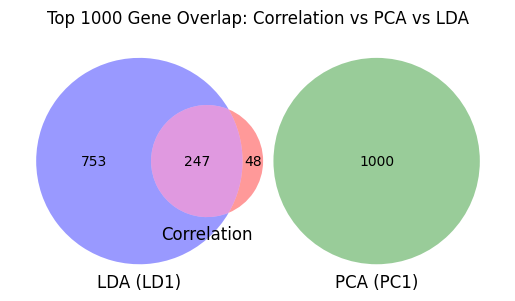

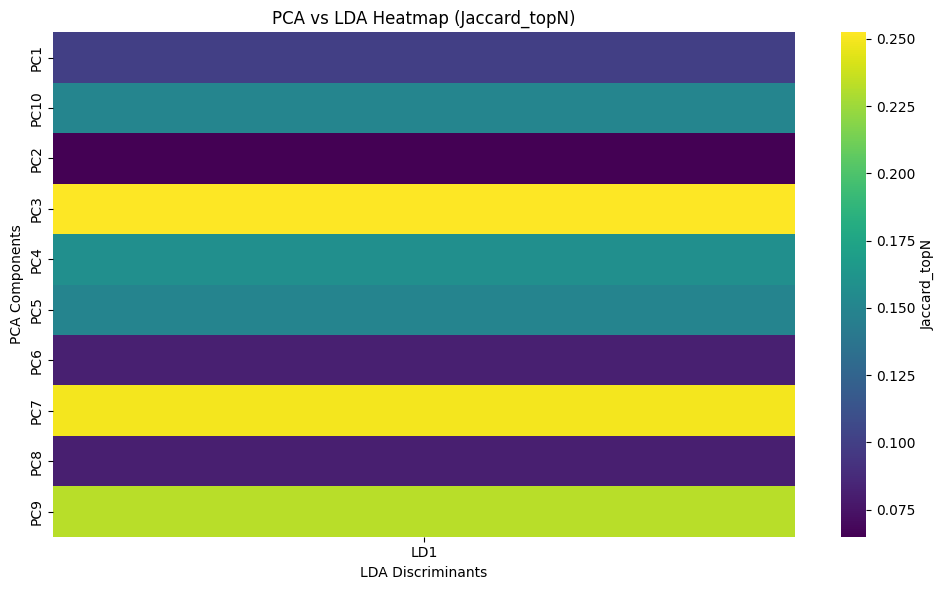

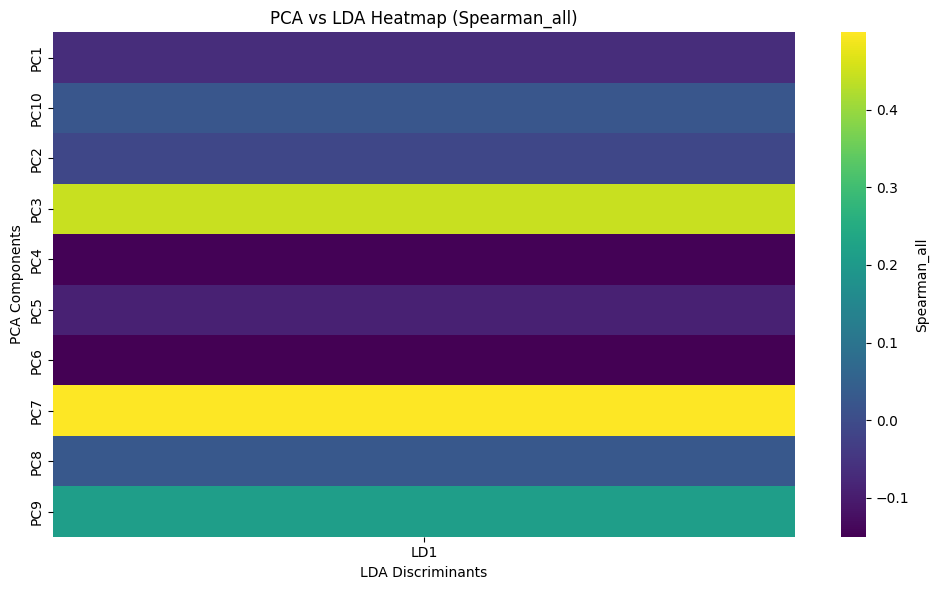

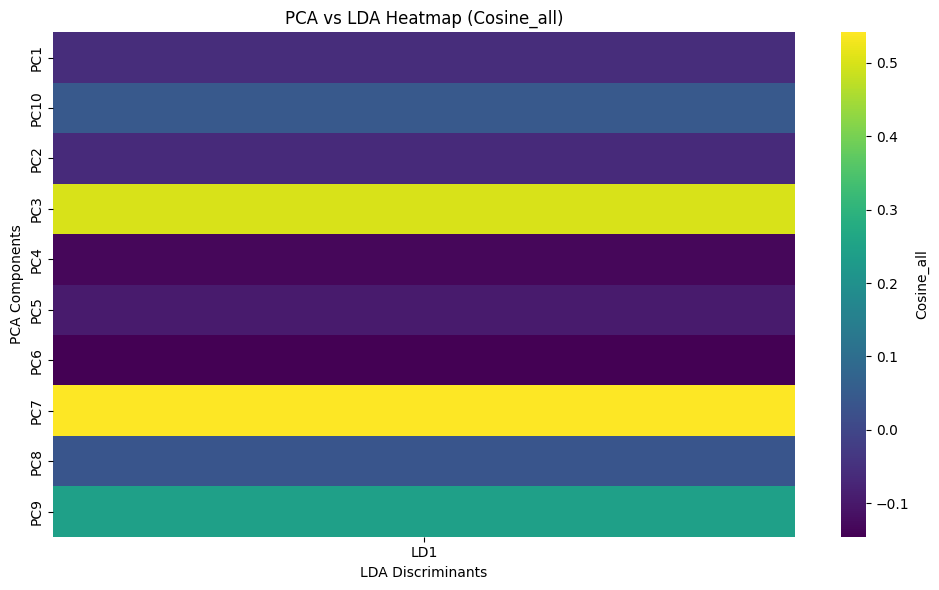

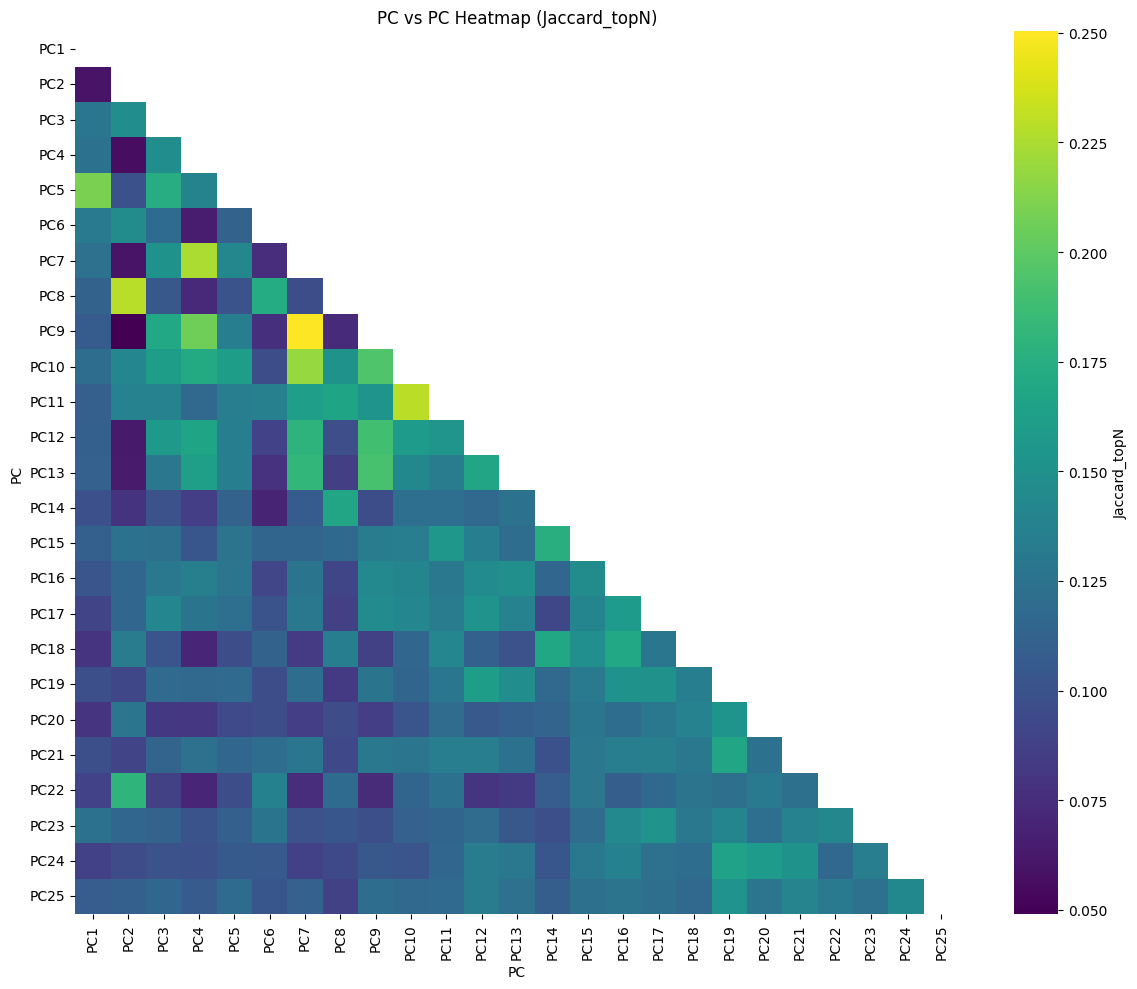

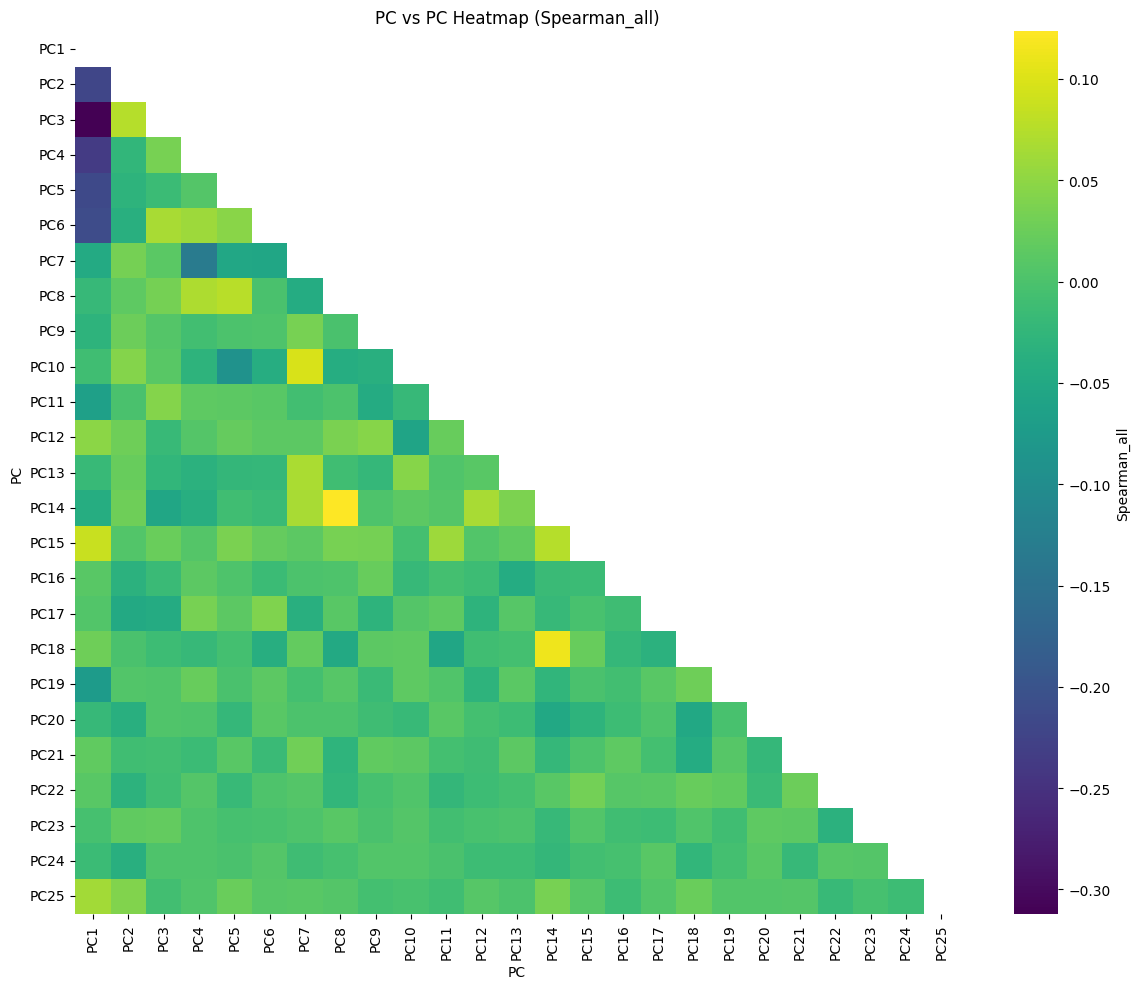

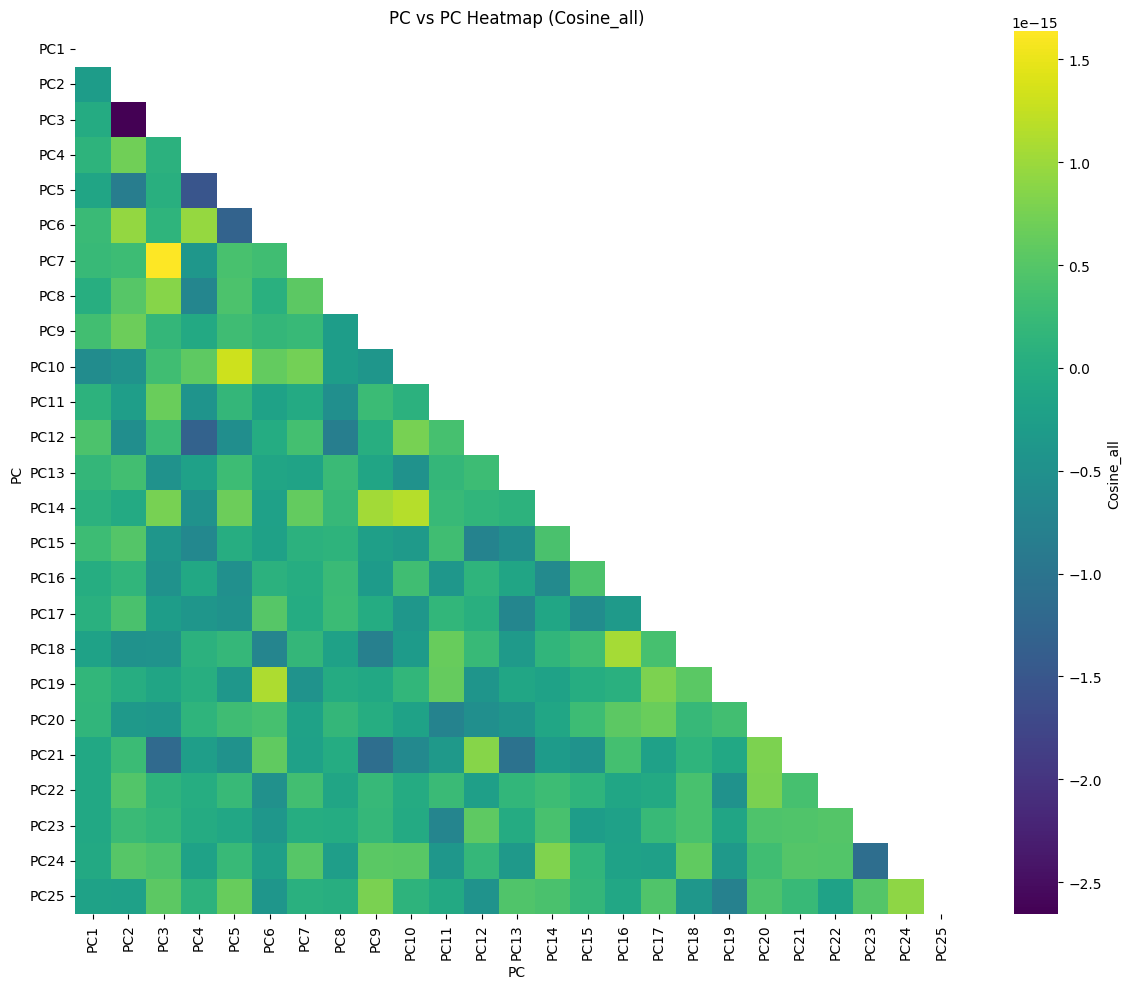

In [30]:
# Step 4: Visualizations
master.venn_correlation_pca_lda()
master.plot_heatmaps()

Loading dataset...
Applying log2 transform to features...


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Selected 295 features with |correlation| > 0.5
Data loaded: 1219 samples, 60660 features. Log=True, Scale=True
Running GPU Incremental PCA...
Incremental PCA completed in 5.58 sec.

Running Stage 2 PCA Tuning...
SparsePCA completed in 1.54 sec.
RotationPCA completed in 1.35 sec.
KernelPCA_rbf completed in 0.67 sec.
KernelPCA_poly completed in 0.46 sec.
KernelPCA_sigmoid completed in 0.86 sec.
SparsePCA completed in 0.85 sec.
SparsePCA completed in 1.87 sec.
SparsePCA completed in 1.34 sec.
SparsePCA completed in 1.16 sec.
SparsePCA completed in 1.48 sec.
SparsePCA completed in 1.93 sec.
SparsePCA completed in 2.89 sec.
RotationPCA completed in 0.61 sec.
RotationPCA completed in 0.39 sec.
RotationPCA completed in 0.39 sec.
RotationPCA completed in 0.41 sec.
RotationPCA completed in 0.38 sec.
RotationPCA completed in 0.42 sec.
RotationPCA completed in 1.82 sec.
RotationPCA completed in 0.83 sec.
RotationPCA completed in 0.54 sec.
RotationPCA completed in 0.52 sec.
RotationPCA completed i

/tmp/ipython-input-1519514949.py:260: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.classifier_tuning_df = pd.concat(all_results, ignore_index=True)


Classifier tuning complete.
Optimal classifier parameters stored.
Cross-validation with optimal parameters complete.

Running LDA tuning...
Best LDA: 20 components (F1=0.9950)
LDA tuning complete.
Revolver scores saved to revolver_scores.csv


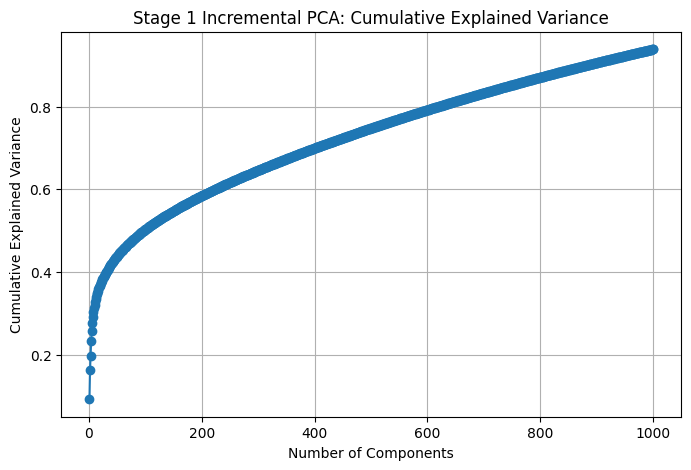

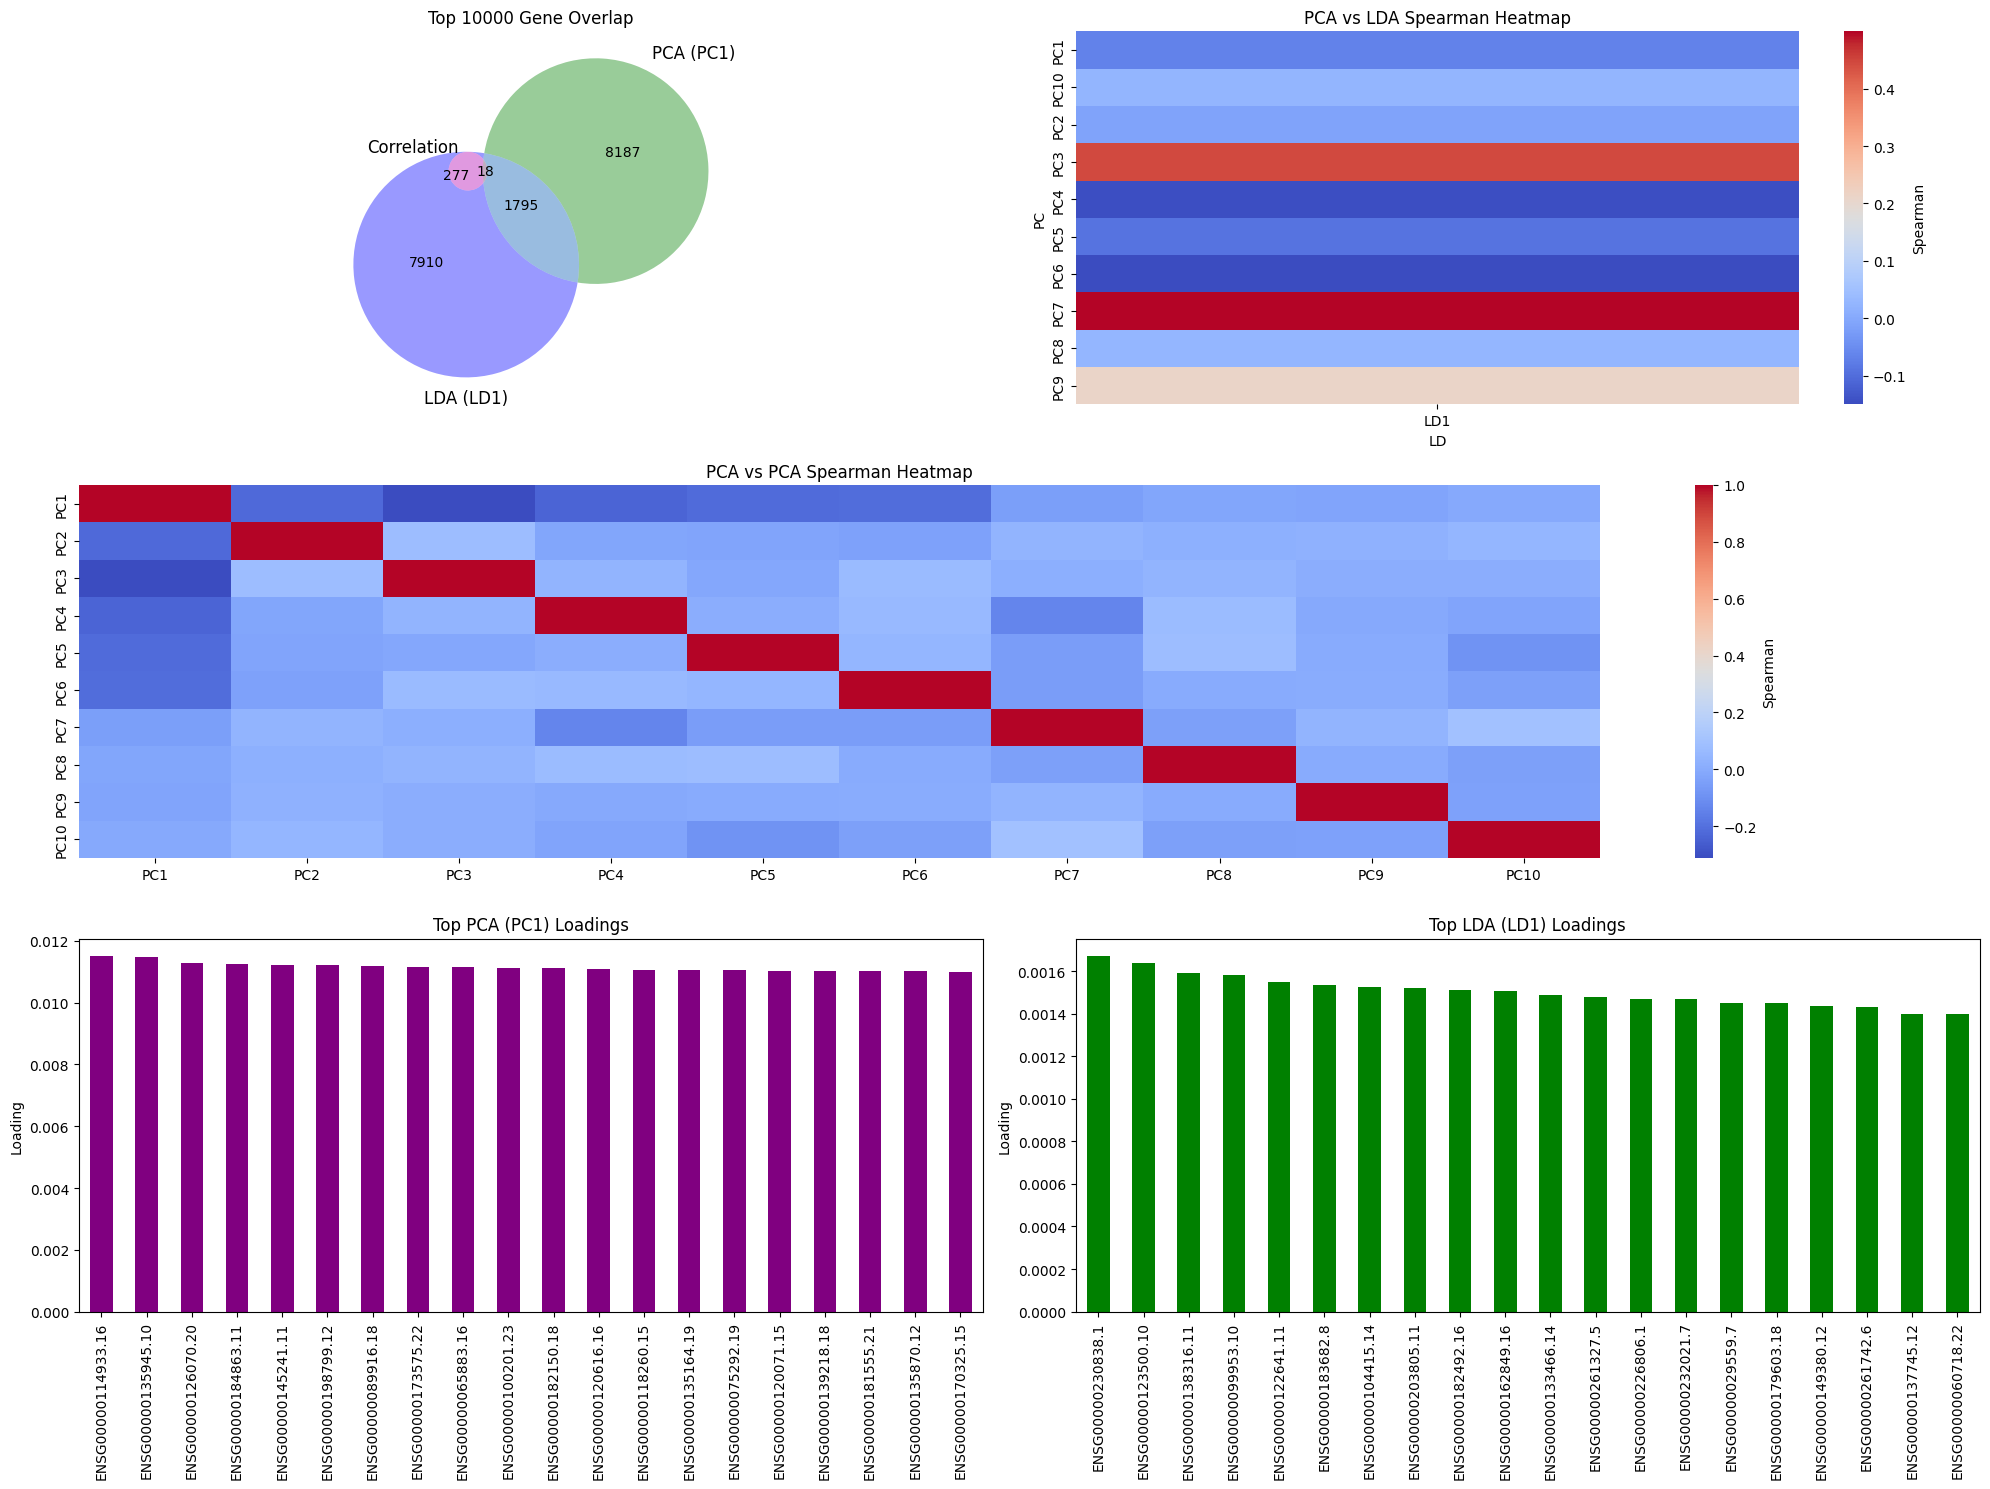

In [31]:
master = MasterPipeline(csv_path, label_col='label')
master.run_correlation_analysis()
master.run_hybrid_pipeline()
master.save_revolver_scores("revolver_scores.csv")
master.plot_cumulative_variance()
master.dashboard_visualization()

In [15]:
mg = mygene.MyGeneInfo()
ensembl_ids = ["ENSG00000000003", "ENSG00000000005", "ENSG00000000419", "ENSG00000000457", "ENSG00000000460"]
results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol,name', species='human')
for r in results:
    print(r['query'], r.get('symbol'), "-", r.get('name'))

INFO:biothings.client:querying 1-5 ...
INFO:biothings.client:Finished.


ENSG00000000003 TSPAN6 - tetraspanin 6
ENSG00000000005 TNMD - tenomodulin
ENSG00000000419 DPM1 - dolichyl-phosphate mannosyltransferase subunit 1, catalytic
ENSG00000000457 SCYL3 - SCY1 like pseudokinase 3
ENSG00000000460 FIRRM - FIGNL1 interacting regulator of recombination and mitosis


In [32]:
# Assuming 'master_pipeline' is your fully initialized pipeline
top_results = master.get_top_hybrid_results(n=10)
print(top_results)

# Export to LaTeX for the paper
print(top_results.to_latex(index=False,
                           columns=["PCA Type", "Classifier", "Precision", "Recall", "F1-Score", "Runtime (s)"],
                           caption="Top 10 PCA–classifier combinations from the Revolver module.",
                           label="tab:revolver_output",
                           float_format="%.4f"))

AttributeError: 'dict' object has no attribute 'sort_values'